In [1]:
import os
import sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import numpy as np

import matplotlib
from matplotlib import pyplot as plt

In [2]:
colab = 1

from google.colab import drive

if colab == 1:
  drive.mount('/content/drive')
  os.chdir('/content/drive/My Drive/Module_6_Colab_Live_Project_Surface_Water/')
  sys.path.append(os.getcwd())
  display(f'{os.getcwd()}')
  display(f'{sys.path}')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


'/content/drive/My Drive/Module_6_Colab_Live_Project_Surface_Water'

"['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/Module_6_Colab_Live_Project_Surface_Water']"

In [3]:
from Python_SQLite_Helper.SQLiteHelper import SQLiteHelper
from Custom_Model.UNETModel import unet_residual

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
input_images_dir = 'Sat_Img_Data/Train/Images/'
input_masks_dir = 'Sat_Img_Data/Train/Masks/'
test_images_dir = 'Sat_Img_Data/Test/Images/'
test_masks_dir = 'Sat_Img_Data/Test/Masks/'

In [6]:
TARGET_WIDTH = TARGET_HEIGHT = 256
BATCH_SIZE = 10

In [7]:
def clip_mask(msk):
  msk[msk < 100] = 0
  msk[msk >= 150] = 255
  return msk

In [8]:
train_data_args = dict(shear_range=0,
                       zoom_range=0,
                       rotation_range=90,
                       rescale=1./255,
                       horizontal_flip=True)

train_mask_args =  dict(shear_range=0,
                        zoom_range=0,
                        rotation_range=90,
                        rescale=1./255,
                        preprocessing_function=clip_mask,
                        horizontal_flip=True)

test_data_args = dict(rescale=1./255)
test_mask_args = dict(rescale=1./255, preprocessing_function=clip_mask)

train_datagen = ImageDataGenerator(**train_data_args)
train_maskgen = ImageDataGenerator(**train_mask_args)

test_datagen = ImageDataGenerator(**test_data_args)
test_maskgen = ImageDataGenerator(**test_mask_args)

In [9]:
def create_generators_for_input(train_images_dir, train_masks_dir,
                                test_images_dir, test_masks_dir):
  
  img_generator = train_datagen.flow_from_directory(train_images_dir,
                                                    target_size=(TARGET_HEIGHT, TARGET_WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode=None, 
                                                    seed=111, 
                                                    shuffle=False)

  mask_generator = train_maskgen.flow_from_directory(train_masks_dir,
                                                     target_size=(TARGET_HEIGHT, TARGET_WIDTH),
                                                     color_mode = 'grayscale',
                                                     batch_size=BATCH_SIZE,
                                                     class_mode=None, 
                                                     seed=111, 
                                                    shuffle=False)

  test_img_generator = test_datagen.flow_from_directory(test_images_dir,
                                                        target_size=(TARGET_HEIGHT, TARGET_WIDTH),
                                                        batch_size=BATCH_SIZE,
                                                        class_mode=None, 
                                                        seed=111,
                                                        shuffle=False)

  test_mask_generator = test_maskgen.flow_from_directory(test_masks_dir,
                                                         target_size=(TARGET_HEIGHT, TARGET_WIDTH),
                                                         color_mode = 'grayscale',
                                                         batch_size=BATCH_SIZE,
                                                         class_mode=None, 
                                                         seed=111,
                                                         shuffle=False)

  train_generator = (pair for pair in zip(img_generator, mask_generator))
  test_generator = (pair for pair in zip(test_img_generator, test_mask_generator))
  return train_generator, test_generator

In [10]:
train_generator, test_generator = create_generators_for_input(input_images_dir, 
                                                              input_masks_dir, 
                                                              test_images_dir, 
                                                              test_masks_dir)

Found 519 images belonging to 1 classes.
Found 519 images belonging to 1 classes.
Found 173 images belonging to 1 classes.
Found 173 images belonging to 1 classes.


In [11]:
def build_callbacks(experiment_label = 'model', 
                    factor = 0.2, min_delta = 0.0001, min_lr = 0.0001,
                    cooldown = 5,
                    patience_lr = 10):

  pickle_path = experiment_label + '.h5'

  checkpoint = ModelCheckpoint(pickle_path, 
                               monitor = 'val_loss', 
                               mode = 'min', 
                               verbose = 1, 
                               save_best_only = True)
  
  reduce_loss = ReduceLROnPlateau(monitor='val_loss', factor = factor, 
                                 patience=patience_lr, 
                                 verbose=1, mode='auto', min_delta=min_delta, 
                                 cooldown=cooldown, min_lr=min_lr)

  cb = [checkpoint, reduce_loss]

  return cb, pickle_path

In [12]:
cb, pickle_path = build_callbacks()

In [13]:
unet_model = unet_residual()

In [14]:
unet_model.train(train_generator, test_generator, BATCH_SIZE,
                 500, 10, 10, cb)

Epoch 1/500
10/10 [==============================] - ETA: 0s - loss: 0.7348
Epoch 00001: val_loss improved from inf to 0.63106, saving model to model.h5
10/10 [==============================] - 103s 10s/step - loss: 0.7348 - val_loss: 0.6311 - lr: 0.0010
Epoch 2/500
10/10 [==============================] - ETA: 0s - loss: 0.3013
Epoch 00002: val_loss improved from 0.63106 to 0.61330, saving model to model.h5
10/10 [==============================] - 90s 9s/step - loss: 0.3013 - val_loss: 0.6133 - lr: 0.0010
Epoch 3/500
10/10 [==============================] - ETA: 0s - loss: 0.2177
Epoch 00003: val_loss improved from 0.61330 to 0.49515, saving model to model.h5
10/10 [==============================] - 62s 6s/step - loss: 0.2177 - val_loss: 0.4951 - lr: 0.0010
Epoch 4/500
10/10 [==============================] - ETA: 0s - loss: 0.2019
Epoch 00004: val_loss did not improve from 0.49515
10/10 [==============================] - 60s 6s/step - loss: 0.2019 - val_loss: 0.6773 - lr: 0.0010
Epoc

In [15]:
def pair_image_with_mask(img, mask):
    mask = mask.squeeze()
    mask = np.stack((mask,)*3, axis=-1)
    return np.concatenate([img, mask], axis = 1)

In [16]:
def show_combined_plots(x, y, batch_sz, fsize):
  cols = 2
  rows = batch_sz//cols
  _, axs = plt.subplots(rows, cols, figsize = fsize)
  axs = axs.flatten()
  for i in range (0, batch_sz):
    combined = pair_image_with_mask(x[i], y[i])
    axs[i].axis('off')
    axs[i].imshow(combined)

  plt.tight_layout()

In [17]:
restored_model = unet_residual()
restored_model.restore('model.h5')

In [18]:
img, msk = next(test_generator)

In [19]:
predicted = restored_model.predict(img)

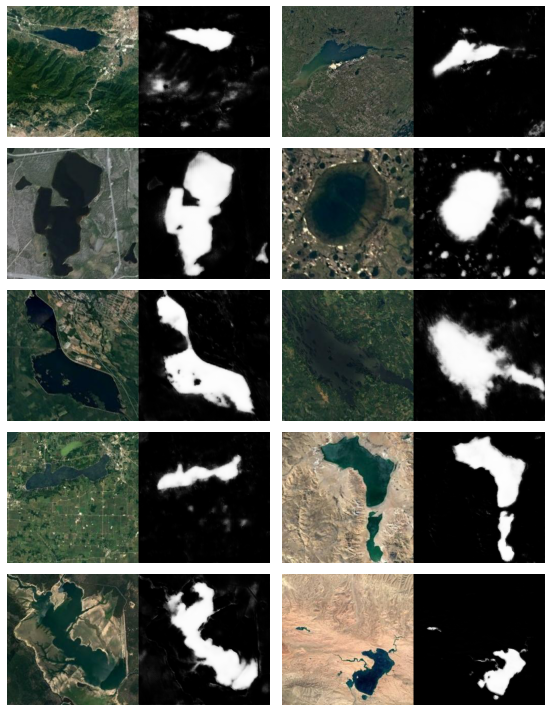

In [20]:
show_combined_plots(img, predicted, BATCH_SIZE, (8, 10))